In [1]:
""" 
GRU-CNN Model Adapted from Maira Alvi's ICONIP21 GitHub Repository:
https://github.com/MairaAlvi/ICONIP21 [Last Accessed: 2022-05-22]
"""

In [2]:
import numpy as np
import pandas as pd
import os
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error


import tensorflow.keras as keras

In [3]:
df = pd.read_csv(os.path.join("data", "final_df.csv"))

In [4]:
df


,pH,Temperature (°C),D.O. (mg/L),Cell Count (million per mL),NO3-N (mg/L),NH4-N (mg/L),ORP (MV),Conductivity (mS/cm),Turbidity (NTU)
0,6.74,15.99,9.84,2.80,11.96,23.50,147.27,0.92,107.16
1,6.85,17.49,10.77,3.14,13.54,23.55,148.10,0.78,94.29
2,6.98,12.96,11.48,2.00,17.28,27.97,133.23,0.80,97.10
3,7.06,12.25,11.86,2.86,20.19,32.24,122.15,0.82,99.01
4,6.94,11.69,11.69,2.46,23.18,32.94,122.98,0.84,99.58
...,...,...,...,...,...,...,...,...,...
172,7.59,10.21,8.38,2.47,20.77,1.03,119.97,2.48,89.10
173,7.60,12.07,8.83,2.64,20.77,1.52,129.58,2.48,80.95
174,7.64,9.69,10.29,3.55,19.73,1.26,116.06,2.54,94.47
175,7.66,13.95,9.62,3.11,20.19,2.17,129.13,2.59,91.79


In [190]:


x_train, x_test, y_train, y_test = model_selection.train_test_split(df.drop(columns=['Cell Count (million per mL)']), df['Cell Count (million per mL)'], test_size=0.25
                                                                    , shuffle=True)



In [191]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.values)
x_test_scaled = scaler.transform(x_test.values)

In [192]:
svr_classifier = SVR()
svr_classifier.fit(x_train, y_train)
svr_prediction = svr_classifier.predict(x_test)


In [193]:
x_test['pred'] = svr_prediction
x_test['true'] = y_test
x_test = x_test.sort_index()

Could not save: plots\2022-05-11 13-30 Combined Acc Predicted and True vs Time.png
Possibly change datetime


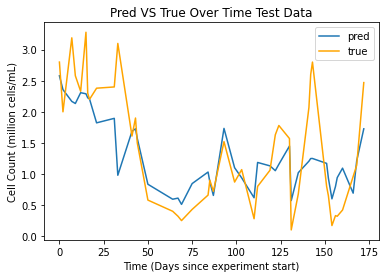

In [194]:
plt.plot(x_test['pred'], label='pred')
plt.plot(x_test['true'], color='orange', label='true')
plt.title('Pred VS True Over Time Test Data')
plt.ylabel('Cell Count (million cells/mL)')
plt.xlabel('Time (Days since experiment start)')
plt.legend()
fpath = os.path.join("plots", now + " Combined Acc Predicted and True vs Time" + ".png")
if check_file(fpath):
    print("Could not save: {0}\nPossibly change datetime".format(fpath))
else:
    plt.savefig(fpath)
plt.show()

In [189]:
mean_squared_error(y_test, svr_prediction)

NameError: name 'root_mean_squared_error' is not defined

In [188]:
np.sqrt(0.6238428025211131)

0.7898372000109346

In [16]:
"""
params = [{
    'kernel': ["poly", "rbf", "sigmoid"],
    'gamma': ["scale", "auto"]    
}]


estimator = GridSearchCV(SVR(), params, scoring='r2', return_train_score=True)
estimator.fit(x_train_scaled, y_train)
best_params = estimator.best_params_

print(best_params)

print(estimator.best_score_)
"""
#OUTPUT
#{'gamma': 'scale', 'kernel': 'poly'}
#0.38909959034873987

'\nparams = [{\n    \'kernel\': ["poly", "rbf", "sigmoid"],\n    \'gamma\': ["scale", "auto"]    \n}]\n\n\nestimator = GridSearchCV(SVR(), params, scoring=\'r2\', return_train_score=True)\nestimator.fit(x_train_scaled, y_train)\nbest_params = estimator.best_params_\n\nprint(best_params)\n\nprint(estimator.best_score_)\n'

In [45]:
x_train_arr = np.array(x_train, np.float32)
x_test_arr = np.array(x_test, np.float32)

x_train_shaped = x_train_arr.reshape(x_train_arr.shape[0], 1, x_train_arr.shape[1])
x_test_shaped = x_test_arr.reshape(x_test_arr.shape[0], 1, x_test_arr.shape[1])

In [46]:
model = keras.models.Sequential([
    keras.layers.GRU(100, return_sequences=True, input_shape=[None, x_train_shaped.shape[2]]),
    keras.layers.GRU(144, return_sequences=True, activation='relu'),
    keras.layers.Reshape(target_shape=(12,12)),
    keras.layers.Conv1D(filters=128, kernel_size=4, strides=1, padding='same',activation='relu'),
    keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'),
    keras.layers.MaxPooling1D((2), strides=None),
    keras.layers.AveragePooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(8, ),
    keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, None, 100)         33000     
                                                                 
 gru_3 (GRU)                 (None, None, 144)         106272    
                                                                 
 reshape_1 (Reshape)         (None, 12, 12)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 128)           6272      
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                      

In [47]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00010),  
              loss='mse',
              metrics=[keras.metrics.RootMeanSquaredError()]
        )

In [48]:
history = model.fit(x_train_shaped,y_train,epochs=200)


Epoch 1/200
5/5 [==============================] - 3s 7ms/step - loss: 2.4201 - root_mean_squared_error: 1.5557
Epoch 2/200
5/5 [==============================] - 0s 5ms/step - loss: 1.9376 - root_mean_squared_error: 1.3920
Epoch 3/200
5/5 [==============================] - 0s 5ms/step - loss: 1.5965 - root_mean_squared_error: 1.2635
Epoch 4/200
5/5 [==============================] - 0s 7ms/step - loss: 1.3361 - root_mean_squared_error: 1.1559
Epoch 5/200
5/5 [==============================] - 0s 5ms/step - loss: 1.1059 - root_mean_squared_error: 1.0516
Epoch 6/200
5/5 [==============================] - 0s 5ms/step - loss: 0.9347 - root_mean_squared_error: 0.9668
Epoch 7/200
5/5 [==============================] - 0s 6ms/step - loss: 0.8197 - root_mean_squared_error: 0.9054
Epoch 8/200
5/5 [==============================] - 0s 6ms/step - loss: 0.7517 - root_mean_squared_error: 0.8670
Epoch 9/200
5/5 [==============================] - 0s 6ms/step - loss: 0.6994 - root_mean_squared_error:

5/5 [==============================] - 0s 4ms/step - loss: 0.1364 - root_mean_squared_error: 0.3693
Epoch 146/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1350 - root_mean_squared_error: 0.3675
Epoch 147/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1305 - root_mean_squared_error: 0.3613
Epoch 148/200
5/5 [==============================] - 0s 5ms/step - loss: 0.1293 - root_mean_squared_error: 0.3596
Epoch 149/200
5/5 [==============================] - 0s 5ms/step - loss: 0.1498 - root_mean_squared_error: 0.3871
Epoch 150/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1295 - root_mean_squared_error: 0.3599
Epoch 151/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1265 - root_mean_squared_error: 0.3557
Epoch 152/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1313 - root_mean_squared_error: 0.3623
Epoch 153/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1333 - root_mean_squared_er

In [49]:
test_eval = model.evaluate(x_test_shaped, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.2780 - root_mean_squared_error: 0.5272


In [50]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error'])

In [51]:
history.history.keys()
test_loss = test_eval[0]
test_rmse = test_eval[1]



In [152]:
now = dt.datetime.now().strftime("%Y-%m-%d %H-%M")

In [53]:
def check_file(fpath):
    return os.path.exists(fpath)

In [54]:
ffp_rmse = min(y_test) * 0.1

In [155]:
test_eval[1]

0.5272206664085388

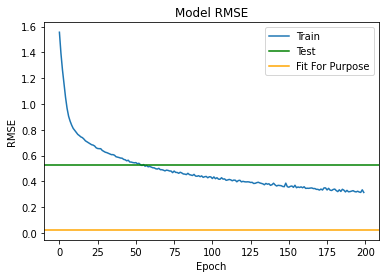

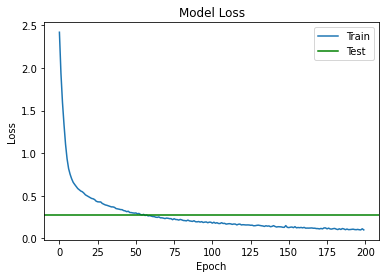

In [55]:
plt.plot(history.history['root_mean_squared_error'], label='Train')
plt.axhline(test_eval[1], color='g', label='Test')
plt.axhline(ffp_rmse, color='orange', label='Fit For Purpose')
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()
fpath = os.path.join("plots", now + " Model RMSE vs Epoch" + ".png")
if check_file(fpath):
    print("Could not save: {0}\nPossibly change datetime".format(fpath))
else:
    plt.savefig(fpath)
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.axhline(test_eval[0], color='g', label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
fpath = os.path.join("plots", now + " Model Loss vs Epoch" + ".png")
if check_file(fpath):
    print("Could not save: {0}\nPossibly change datetime".format(fpath))
else:
    plt.savefig(fpath)
plt.show()

In [74]:
pred_train = model.predict(x_train_shaped)
sort_train = x_train
sort_train['pred_train'] = pred_train
sort_train['y_train'] = y_train
sort_train = sort_train.sort_index()

In [76]:
sort_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 0 to 176
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pH                    141 non-null    float64
 1   Temperature (°C)      141 non-null    float64
 2   D.O. (mg/L)           141 non-null    float64
 3   NO3-N (mg/L)          141 non-null    float64
 4   NH4-N (mg/L)          141 non-null    float64
 5   ORP (MV)              141 non-null    float64
 6   Conductivity (mS/cm)  141 non-null    float64
 7   Turbidity (NTU)       141 non-null    float64
 8   pred_train            141 non-null    float32
 9   y_train               141 non-null    float64
dtypes: float32(1), float64(9)
memory usage: 11.6 KB


In [57]:

pred_test = model.predict(x_test_shaped)
sort_test = x_test
sort_test['pred_test'] = pred_test
sort_test['y_test'] = y_test
sort_test = sort_test.sort_index()


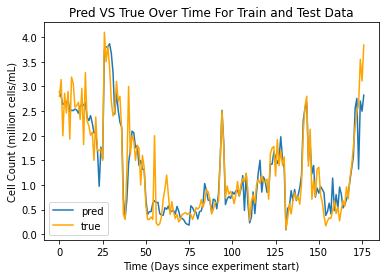

In [153]:

pred_df = pd.concat([sort_train['pred_train'], sort_test['pred_test']], axis=1)
pred_df['combined_pred'] = pred_df['pred_train'].fillna(pred_df['pred_test'])
true_df = pd.concat([sort_train['y_train'], sort_test['y_test']], axis=1)
true_df['combined_true'] = true_df['y_train'].fillna(true_df['y_test'])

plt.plot(pred_df['combined_pred'], label='pred')
plt.plot(true_df['combined_true'], color='orange', label='true')
plt.title('Pred VS True Over Time For Train and Test Data')
plt.ylabel('Cell Count (million cells/mL)')
plt.xlabel('Time (Days since experiment start)')
plt.legend()
fpath = os.path.join("plots", now + " Combined Acc Predicted and True vs Time" + ".png")
if check_file(fpath):
    print("Could not save: {0}\nPossibly change datetime".format(fpath))
else:
    plt.savefig(fpath)
plt.show()

